In [1]:
import warnings 
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import json

2024-04-28 19:54:29.127203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 19:54:29.127298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 19:54:29.276045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if GPU is available or not

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [3]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


In [4]:
parameters = {}
parameters['number_of_users_in_total'] = len(users_sequences)
parameters['number_of_sequences_in_total'] = len(users_sequences)

#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [5]:
min_num_of_products_in_sequence = 4
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 372436


In [6]:
parameters['min_num_of_products_in_sequence'] = min_num_of_products_in_sequence
parameters['number_of_sequences_after_filtering'] = len(filtered_users_sequences)
parameters['number_of_users_after_filtering'] = len(filtered_users_sequences)

#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [7]:
sequence_length = 30

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

In [8]:
parameters['sequence_length'] = sequence_length

#### Assigning obtained datasets to a clearer form

In [9]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533, 108535], [0,

In [10]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1609472
Number of validation sequences: 372436
Number of test sequences: 372436

Number of train targets: 1609472
Number of validation targets: 372436
Number of test targets: 372436


In [11]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

-------

### Defining metrics

#### F1@k

In [12]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [13]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [14]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [15]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

-------

## Bidirectional-LSTM

In [16]:
hyperparameters = {
    'output_dim_embedding_layer': 50,
    'num_bi_lstm_layers': 1,
    'num_units_bi_lstm_layer_1': 8,
    'activ_fun_bi_lstm_layer_1': 'relu',
    'num_batch_norm_layers': 1,
    'num_dropout_layers': 1,
    'dropout_rate_layer_1': 0.2,
    'num_dense_layers': 2,
    'num_units_dense_layer_1': 16,
    'activ_fun_dense_layer_1': 'relu',
    'optimizer': 'adam',
    'learning_rate': 0.001,
    'batch_size': 512
}

#### Preprocessing datasets for faster processing

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(hyperparameters['batch_size'])
val_dataset = val_dataset.batch(hyperparameters['batch_size'])
test_dataset = test_dataset.batch(hyperparameters['batch_size'])

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

#### Model definition

In [18]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=hyperparameters['output_dim_embedding_layer'], mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(hyperparameters['num_units_bi_lstm_layer_1'], activation=hyperparameters['activ_fun_bi_lstm_layer_1'])))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(hyperparameters['dropout_rate_layer_1']))
#model_bi_lstm.add(Bidirectional(LSTM(hyperparameters['num_units_bi_lstm_layer_2'], activation=hyperparameters['activ_fun_bi_lstm_layer_2'])))
#model_bi_lstm.add(BatchNormalization())
#model_bi_lstm.add(Dropout(hyperparameters['dropout_rate_layer_2']))
model_bi_lstm.add(Dense(hyperparameters['num_units_dense_layer_1'], activation=hyperparameters['activ_fun_dense_layer_1']))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=hyperparameters['learning_rate']), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

#### Model training

In [19]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=hyperparameters['batch_size'],
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   3/3144 ━━━━━━━━━━━━━━━━━━━━ 2:07 41ms/step - accuracy: 2.1701e-04 - f1_score_at_k: 2.0661e-04 - hit_rate_at_k: 0.0011 - loss: 11.8816 - ndcg_at_k: 2.3175e-04      

I0000 00:00:1714334318.149585     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714334318.235840     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3144/3144 ━━━━━━━━━━━━━━━━━━━━ 141s 42ms/step - accuracy: 0.0242 - f1_score_at_k: 0.0104 - hit_rate_at_k: 0.0498 - loss: 9.8571 - ndcg_at_k: 0.0127 - val_accuracy: 0.0571 - val_f1_score_at_k: 0.0493 - val_hit_rate_at_k: 0.0806 - val_loss: 11.7346 - val_ndcg_at_k: 0.0235
Epoch 2/25
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 123s 39ms/step - accuracy: 0.0589 - f1_score_at_k: 0.0408 - hit_rate_at_k: 0.0933 - loss: 8.7267 - ndcg_at_k: 0.0261 - val_accuracy: 0.0808 - val_f1_score_at_k: 0.0682 - val_hit_rate_at_k: 0.1032 - val_loss: 8.9858 - val_ndcg_at_k: 0.0313
Epoch 3/25
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 124s 39ms/step - accuracy: 0.0752 - f1_score_at_k: 0.0553 - hit_rate_at_k: 0.1101 - loss: 8.4559 - ndcg_at_k: 0.0317 - val_accuracy: 0.0915 - val_f1_score_at_k: 0.0745 - val_hit_rate_at_k: 0.1125 - val_loss: 8.9049 - val_ndcg_at_k: 0.0347
Epoch 4/25
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 123s 39ms/step - accuracy: 0.0842 - f1_score_at_k: 0.0629 - hit_rate_at_k: 0.1191 - loss: 8.2877 - ndcg_at_k: 0.0348 - val_ac

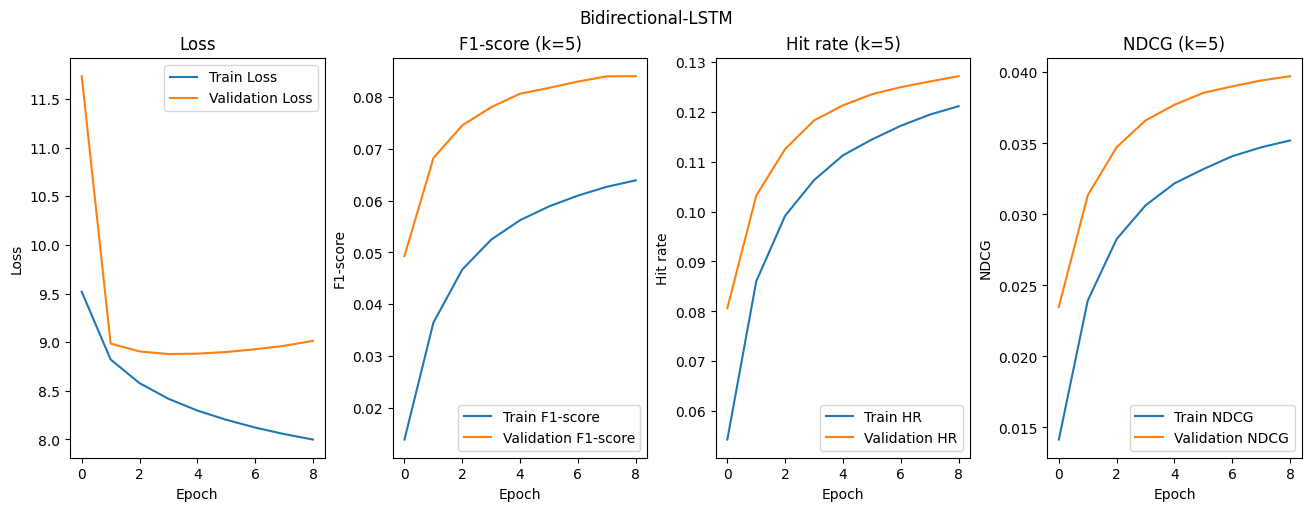

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [21]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score"] = round(model_bi_lstm_test_f1_score, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

728/728 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.0893 - f1_score_at_k: 0.0738 - hit_rate_at_k: 0.1044 - loss: nan - ndcg_at_k: 0.0329
Test loss: nan
Test accuracy: 0.0789
Test F1@5: 0.0641
Test HR@5: 0.0948
Test NDCG@5: 0.0296


In [22]:
parameters.update(hyperparameters)
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'min_num_of_products_in_sequence': 4,
 'number_of_sequences_after_filtering': 372436,
 'number_of_users_after_filtering': 372436,
 'sequence_length': 30,
 'number_of_sequences_and_targets_train': 1609472,
 'number_of_sequences_and_targets_validation': 372436,
 'number_of_sequences_and_targets_test': 372436,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0789,
 'model_bi_lstm_test_f1_score': 0.0641,
 'model_bi_lstm_test_hr': 0.0948,
 'model_bi_lstm_test_ndcg': 0.0296,
 'output_dim_embedding_layer': 50,
 'num_bi_lstm_layers': 1,
 'num_units_bi_lstm_layer_1': 8,
 'activ_fun_bi_lstm_layer_1': 'relu',
 'num_batch_norm_layers': 1,
 'num_dropout_layers': 1,
 'dropout_rate_layer_1': 0.2,
 'num_dense_layers': 2,
 'num_units_dense_layer_1': 16,
 'activ_fun_dense_layer_1': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'batch_size': 512}